In [1]:
#Written by Roc Chow, March 2020

In [2]:
#import libraries
import pandas as pd
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read all csv files under the same directory
def readallcsv():
    allcsv = glob.glob("./*.csv")
    print("The following DataFrame will be created: ")
    for f in allcsv:
        print(f.split('.')[1][1:])
        globals()[f.split('.')[1][1:]] = pd.read_csv(f)


In [4]:
readallcsv()

The following DataFrame will be created: 
calendar
sales_train_validation
sample_submission
sell_prices


In [5]:
# Dataframe preparation

# use melt to aggregate d1-d_1913 to d column with count as demand
sales_train_validation_melt = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='demand')
# extend d column to d_num
sales_train_validation_melt['d_num'] = sales_train_validation_melt.d.str.split('_', n=1, expand=True)[1].astype(int)

# reduce the dataframe size to start from Day1000(to avoid memory error), later can adjust to earlier day if permitted
sales_train_validation_melt_1000 = sales_train_validation_melt[sales_train_validation_melt.d_num > 999]

# bringing in calendar dataframe joining on d column
sales_cal_join = pd.merge(sales_train_validation_melt_1000, calendar, on='d')

# joining price into the dataframe
sales_cal_price_join = pd.merge(sales_cal_join, sell_prices, on=['store_id','item_id', 'wm_yr_wk'] )

In [6]:
prophet_df = sales_cal_join[['date', 'store_id','dept_id','item_id','demand' ]]

In [7]:
from fbprophet import Prophet
def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=True,daily_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=28*2, include_history=False)
    forecast = model.predict(forecast)
    model.plot(forecast)
    return forecast

**Facebook Prophet**

Utilizing more CPU power<br>
https://medium.com/spikelab/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245

In [60]:
calendar.tail(28*2+1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1912,2016-04-24,11613,Sunday,2,4,2016,d_1913,NaN,NaN,NaN,NaN,0,0,0
1913,2016-04-25,11613,Monday,3,4,2016,d_1914,NaN,NaN,NaN,NaN,0,0,0
1914,2016-04-26,11613,Tuesday,4,4,2016,d_1915,NaN,NaN,NaN,NaN,0,0,0
1915,2016-04-27,11613,Wednesday,5,4,2016,d_1916,NaN,NaN,NaN,NaN,0,0,0
1916,2016-04-28,11613,Thursday,6,4,2016,d_1917,NaN,NaN,NaN,NaN,0,0,0
1917,2016-04-29,11613,Friday,7,4,2016,d_1918,NaN,NaN,NaN,NaN,0,0,0
1918,2016-04-30,11614,Saturday,1,4,2016,d_1919,Pesach End,Religious,NaN,NaN,0,0,0
1919,2016-05-01,11614,Sunday,2,5,2016,d_1920,OrthodoxEaster,Religious,NaN,NaN,1,1,0
1920,2016-05-02,11614,Monday,3,5,2016,d_1921,NaN,NaN,NaN,NaN,1,0,1
1921,2016-05-03,11614,Tuesday,4,5,2016,d_1922,NaN,NaN,NaN,NaN,1,1,1


In [8]:
prophet_df.head()

,date,store_id,dept_id,item_id,demand
0,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_001,0
1,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_002,0
2,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_003,0
3,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_004,1
4,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_005,1


In [86]:
prophet_group = prophet_df.groupby(['date','store_id','dept_id'], as_index=False).agg({'item_id':'count','demand':'sum'})

In [87]:
prophet_group.head()

,date,store_id,dept_id,item_id,demand
0,2013-10-24,CA_1,FOODS_1,216,243
1,2013-10-24,CA_1,FOODS_2,398,247
2,2013-10-24,CA_1,FOODS_3,823,1636
3,2013-10-24,CA_1,HOBBIES_1,416,312
4,2013-10-24,CA_1,HOBBIES_2,149,30


FOODS_1
FOODS_2
Wall time: 13.4 s


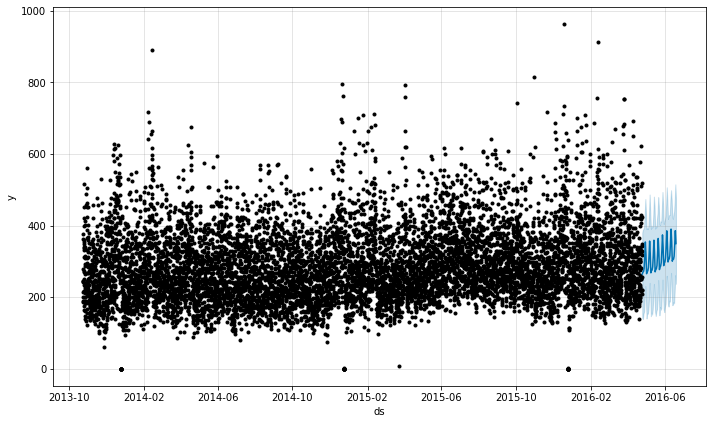

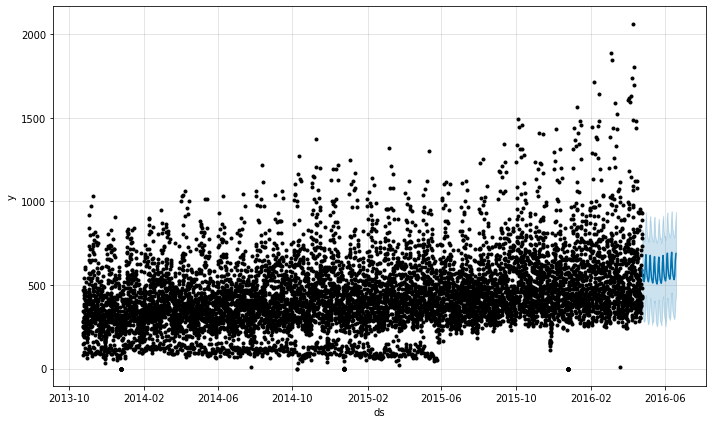

In [93]:
%%time
dept_list = prophet_group.dept_id.unique()
for i in np.arange(2):
    f = run_prophet(prophet_group[prophet_group['dept_id']==dept_list[i]][['date','demand']].rename(columns={"date": "ds", "demand": "y"}))
    print(dept_list[i])
    i+=1

In [118]:
prophet_df.head()

,date,store_id,dept_id,item_id,demand
0,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_001,0
1,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_002,0
2,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_003,0
3,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_004,1
4,2013-10-24,CA_1,HOBBIES_1,HOBBIES_1_005,1


In [125]:
[prophet_df['item_id']==item_list[0]][['date','demand']]

TypeError: list indices must be integers or slices, not list

In [9]:
from fbprophet.diagnostics import cross_validation
m = Prophet()
item_list = prophet_df.item_id.unique()
df = prophet_df[prophet_df['item_id']==item_list[0]][['date','demand']].rename(columns={"date": "ds", "demand": "y"})
m.fit(df)
df_cv = cross_validation(m, initial='700 days', period='7 days', horizon = '28 days')
df_cv.head(10)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2015-09-27 00:00:00 and 2016-03-27 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-09-28,0.46102,-0.387152,1.350241,2,2015-09-27
1,2015-09-28,0.46102,-0.471399,1.389042,0,2015-09-27
2,2015-09-28,0.46102,-0.410508,1.348721,2,2015-09-27
3,2015-09-28,0.46102,-0.437236,1.319089,0,2015-09-27
4,2015-09-28,0.46102,-0.404496,1.401098,0,2015-09-27
5,2015-09-28,0.46102,-0.371253,1.425208,0,2015-09-27
6,2015-09-28,0.46102,-0.461327,1.313455,1,2015-09-27
7,2015-09-28,0.46102,-0.418129,1.345935,0,2015-09-27
8,2015-09-28,0.46102,-0.446730,1.385140,1,2015-09-27
9,2015-09-28,0.46102,-0.471048,1.342346,0,2015-09-27


In [11]:
df_cv.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-09-28,0.46102,-0.387152,1.350241,2,2015-09-27
1,2015-09-28,0.46102,-0.471399,1.389042,0,2015-09-27
2,2015-09-28,0.46102,-0.410508,1.348721,2,2015-09-27
3,2015-09-28,0.46102,-0.437236,1.319089,0,2015-09-27
4,2015-09-28,0.46102,-0.404496,1.401098,0,2015-09-27
5,2015-09-28,0.46102,-0.371253,1.425208,0,2015-09-27
6,2015-09-28,0.46102,-0.461327,1.313455,1,2015-09-27
7,2015-09-28,0.46102,-0.418129,1.345935,0,2015-09-27
8,2015-09-28,0.46102,-0.446730,1.385140,1,2015-09-27
9,2015-09-28,0.46102,-0.471048,1.342346,0,2015-09-27


In [13]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,0.684337,0.827247,0.652745,inf,0.893915
1,4 days,0.678683,0.823822,0.638598,inf,0.903175
2,5 days,0.681185,0.825339,0.641354,inf,0.904233
3,6 days,0.748799,0.865332,0.680916,inf,0.878836
4,7 days,0.840460,0.916766,0.719455,inf,0.856614
5,8 days,0.765085,0.874691,0.701261,inf,0.861376
6,9 days,0.717038,0.846781,0.673545,inf,0.882275
7,10 days,0.691936,0.831827,0.654379,inf,0.893651
8,11 days,0.694127,0.833143,0.643081,inf,0.900529
9,12 days,0.686285,0.828423,0.644020,inf,0.901852


In [6]:
print(sales_train_validation.shape)
print(sales_train_validation_melt.shape)
print(sales_cal_join.shape)
print(sales_cal_price_join.shape)

(30490, 1919)
(58327370, 9)
(27867860, 22)
(26600086, 23)


When bringing in price, inner join lost some rows(sales_cal_price_join has less rows) meaning, some iteams do not provide price and will drop them.

**Old Part**

Take a look at the joined df

In [7]:
sales_cal_price_join.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'demand', 'd_num', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [8]:
sales_cal_price_join.dtypes

id               object
item_id          object
dept_id          object
cat_id           object
store_id         object
state_id         object
d                object
demand            int64
d_num             int32
date             object
wm_yr_wk          int64
weekday          object
wday              int64
month             int64
year              int64
event_name_1     object
event_type_1     object
event_name_2     object
event_type_2     object
snap_CA           int64
snap_TX           int64
snap_WI           int64
sell_price      float64
dtype: object

Fixing some of the datatypes

In [9]:
# chaning date type to datetime
sales_cal_price_join.date = pd.to_datetime(sales_cal_price_join.date)

In [10]:
sales_cal_price_join.date.head()

0   2013-10-24
1   2013-10-25
2   2013-10-24
3   2013-10-25
4   2013-10-24
Name: date, dtype: datetime64[ns]

Picked a few features to train below

In [12]:
min_df = sales_cal_price_join[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_num',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year','sell_price']]

DF preparation pipeline including OneHotEncoder

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# dividing categorical and numerical columns
cat_col = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'weekday', 'wday', 'month', 'year']
num_col = ['d_num','wm_yr_wk','sell_price']

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_col),
        ("cat", OneHotEncoder(), cat_col),
    ])

min_df_prepared = full_pipeline.fit_transform(min_df)

In [ ]:
min_df_prepared

In [14]:
X_train = min_df_prepared
y_train = min_df.demand

In [10]:
from sklearn.model_selection import TimeSeriesSplit

Training

In [16]:
from sklearn.svm import SVR

In [17]:
svr_clf = SVR(C=1.0, epsilon=0.2)

In [ ]:
# runs too long, to be tweaked
svr_clf.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
sample_submission.head()

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
tscv = TimeSeriesSplit(n_splits=5)
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    for mf in np.linspace(100, 150, 2):
        for ne in np.linspace(50, 100, 2):
            for md in np.linspace(20, 40, 2):
                for msl in np.linspace(30, 100, 2):
                    rfr = RandomForestRegressor(
                        max_features=int(mf),
                        n_estimators=int(ne),
                        max_depth=int(md),
                        min_samples_leaf=int(msl), verbose=1, n_jobs=5)
                    rfr.fit(X_tr, y_tr)
                    score.append([i,
                                  mf, 
                                  ne,
                                  md, 
                                  msl, 
                                  rfr.score(X_val, y_val)])
                    print([i,mf, ne, md,  msl,  rfr.score(X_val, y_val)])

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  2.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    6.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    7.2s finished


[1, 100.0, 50.0, 20.0, 30.0, 0.08944016622257267]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  2.0min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    7.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    6.8s finished


[1, 100.0, 50.0, 20.0, 100.0, 0.07753714475282292]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  5.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.6s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   10.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.7s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   10.9s finished


[1, 100.0, 50.0, 40.0, 30.0, 0.14139402493365671]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  4.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   12.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   13.0s finished


[1, 100.0, 50.0, 40.0, 100.0, 0.11281163534758976]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   17.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   18.8s finished


[1, 100.0, 100.0, 20.0, 30.0, 0.08700508064127865]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   19.6s finished


[1, 100.0, 100.0, 20.0, 100.0, 0.0695686286386833]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  6.8min


KeyboardInterrupt: 

Time series cross validation<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html<br>
http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/<br>
https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8<br>

In [57]:
# visulizing time series split
tscv = TimeSeriesSplit(n_splits=5)
train_list =[]
val_list=[]

for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    train_list.append(y_tr.size)
    val_list.append(y_val.size) 

train_val_ratio = {'train':train_list, 'val':val_list}    
train_val_df=pd.DataFrame(data=train_val_ratio)

In [58]:
train_val_df

,train,val
0,4433351,4433347
1,8866698,4433347
2,13300045,4433347
3,17733392,4433347
4,22166739,4433347


In [59]:
tscv = TimeSeriesSplit(n_splits=10)
train_list =[]
val_list=[]

for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    train_list.append(y_tr.size)
    val_list.append(y_val.size) 

train_val_ratio = {'train':train_list, 'val':val_list}    
train_val_df=pd.DataFrame(data=train_val_ratio)

In [60]:
train_val_df

,train,val
0,2418196,2418189
1,4836385,2418189
2,7254574,2418189
3,9672763,2418189
4,12090952,2418189
5,14509141,2418189
6,16927330,2418189
7,19345519,2418189
8,21763708,2418189
9,24181897,2418189


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt


svm_poly_reg = SVR(kernel="poly", degree=3, C=100, epsilon=0.1, verbose=1, gamma=auto)

for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    svm_poly_reg.fit(X_tr, y_tr)
    y_pridicted = svm_poly_reg.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pridicted))
    print(rmse)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
?SVR